In [1]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
#ignore
#%config Completer.use_jedi = False

In [ ]:
# import io
# from google.colab import files
# from google.colab import drive

# uploaded = files.upload()
# drive.mount('/content/drive')

# loading Dataset

In [76]:
trips = pd.read_parquet(path="F:/ML_Project/Datasets/NYCtaxi/yellow_tripdata_2023-01.parquet")
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [77]:
trips = trips.reset_index()

In [78]:
#load locationID lookup table
zonedb = pd.read_csv('F:/ML_Project/Datasets/NYCtaxi/taxi+_zone_lookup.csv', header=0)
zonedb.set_index('LocationID')

,Borough,Zone,service_zone
LocationID,,,
1,EWR,Newark Airport,EWR
2,Queens,Jamaica Bay,Boro Zone
3,Bronx,Allerton/Pelham Gardens,Boro Zone
4,Manhattan,Alphabet City,Yellow Zone
5,Staten Island,Arden Heights,Boro Zone
...,...,...,...
261,Manhattan,World Trade Center,Yellow Zone
262,Manhattan,Yorkville East,Yellow Zone
263,Manhattan,Yorkville West,Yellow Zone


# dataset description

In [4]:
trips.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


# column domain attributes

In [5]:
vendor_id = dict({1:"Creative Mobile Technologies, LLC",
                  2: "VeriFone Inc"})

ratecodeid = dict({1: "Standard rate",
                    2: "JFK",
                    3: "Newark",
                    4: "Nassau or Westchester",
                    5: "Negotiated fare",
                    6: "Group ride"})

store_and_fwd_flag = dict({"Y": "store and forward trip",
                    "N": "not a store and forward trip"})

payment_type = dict({0: "Credit card",
                    1: "Cash",
                    2: "No charge",
                    3: "Dispute",
                    4: "Unknown",
                    5: "Voided trip"})

weekd = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thrusday', 5:
         'Friday', 6:'Saturday', 7:'Sunday'}

# Questionare -
What we want to find?<br>
* Most popular mode of payment by volumn?
* Most busy days of a week?
* Most popular pickup and dropoff location?
* Revenue by ratecodes


# Most popular mode of payment by volumn?

In [6]:
#using groupby to group on payment type
db = trips.groupby(by=['payment_type']).count()[['index']]
#reseting index
db.index = list(map(lambda x: payment_type[x], db.index))
db.sort_values(by='index', ascending=False)

,index
Cash,2411462
No charge,532241
Credit card,71743
Unknown,33297
Dispute,18023


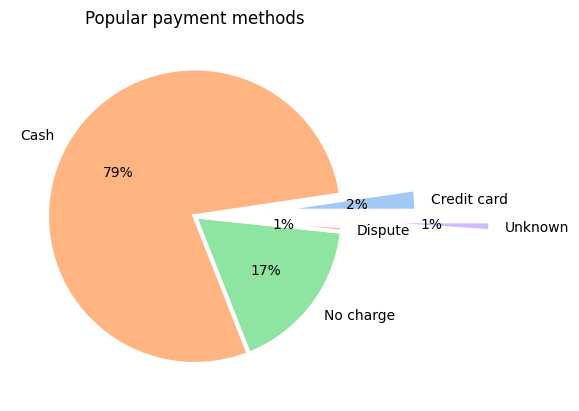

In [7]:
# visualize the numbers in pie chart
plt.pie(db['index'], explode=[0.5,0,0,0,1], autopct='%.0f%%', labels=db.index,
        colors=sns.color_palette('pastel', n_colors=5),
        wedgeprops = {'linewidth': 3, 'edgecolor': 'white'},
        textprops={'color':'black'})
plt.title("Popular payment methods")
plt.show()

# Most busy days of a week?
By number of trips

In [8]:
#copy part of trips dataset of above purpose
bdays = trips[['index','tpep_pickup_datetime','tpep_dropoff_datetime']].copy()
bdays.head(5)

,index,tpep_pickup_datetime,tpep_dropoff_datetime
0,0,2023-01-01 00:32:10,2023-01-01 00:40:36
1,1,2023-01-01 00:55:08,2023-01-01 01:01:27
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49
3,3,2023-01-01 00:03:48,2023-01-01 00:13:25
4,4,2023-01-01 00:10:29,2023-01-01 00:21:19


In [9]:
#Data preprocessing: Removing unneccessary
print("Whole dataset:\n", bdays.resample('M', on='tpep_pickup_datetime').count()['index'])

#extracting 2023
bdays = bdays[bdays['tpep_pickup_datetime'].dt.year == 2023]
print("2023 data only: ",len(bdays), "instances")

Whole dataset:
 tpep_pickup_datetime
2008-12-31          2
2009-01-31          0
2009-02-28          0
2009-03-31          0
2009-04-30          0
               ...   
2022-10-31         11
2022-11-30          0
2022-12-31         25
2023-01-31    3066718
2023-02-28         10
Freq: M, Name: index, Length: 171, dtype: int64
2023 data only:  3066728 instances


### Weekday preprocess
help in grouping according to weekdays

In [10]:
#add weekday column
bdays['weekday'] = bdays['tpep_pickup_datetime'].apply(func=lambda x: x.isoweekday())

In [12]:
#groupby weekday
db1 = bdays.groupby(by='weekday').count()['index'].reset_index()
db1['weekday'] = db1['weekday'].apply(lambda x: weekd[x])
db1.sort_values(by='index', ascending=False)

,weekday,index
1,Tuesday,490981
3,Thrusday,441929
5,Saturday,441630
6,Sunday,436434
4,Friday,434381
2,Wednesday,416568
0,Monday,404805


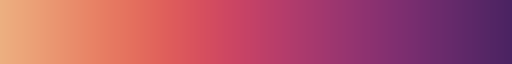

In [14]:
#choosing a colormap for bar chart illustration
colormap = plt.get_cmap('flare')
#mapping values to color-range from lighter to darker
normalize = plt.Normalize(vmin=db1['index'].min(), vmax=db1['index'].max())
colormap

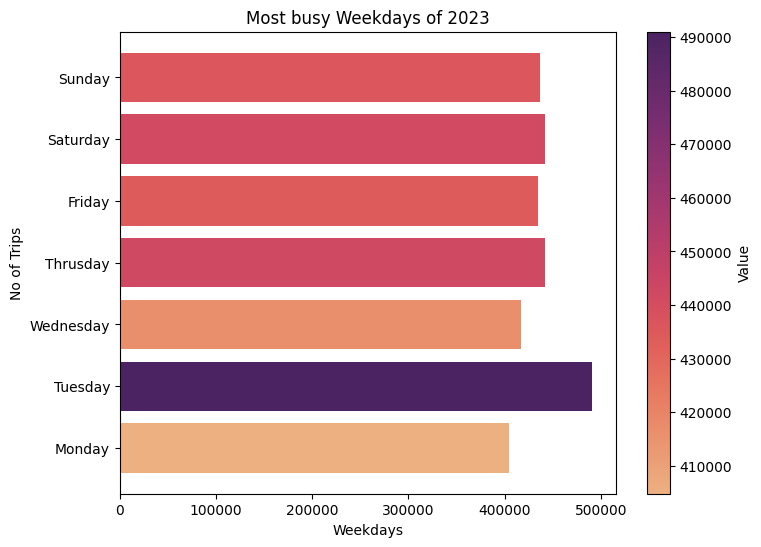

In [15]:
# visualization
fig, ax = plt.subplots(figsize=(8,6))
plt.barh(y=db1['weekday'], width=db1['index'],
        color= colormap(normalize(db1['index']))
)
# display colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=normalize), ax=ax, orientation='vertical')
cbar.set_label('Value')

# Set labels and title
plt.xlabel('Weekdays')
plt.ylabel('No of Trips')
plt.title('Most busy Weekdays of 2023')

# Show the plot
plt.show()

# Most popular pickup and dropoff location?

In [16]:
# extracting neccessary data
plocs = trips[trips['tpep_pickup_datetime'].dt.year == 2023]
plocs = plocs[['index','PULocationID','DOLocationID','tpep_pickup_datetime']].copy()
plocs.shape

(3066728, 4)

In [17]:
# unique locations
print(f"UNIQUE Locations:\n pickup:{plocs.PULocationID.unique().size}\n dropoff:{plocs.DOLocationID.unique().size}")

UNIQUE Locations:
 pickup:257
 dropoff:261


In [18]:
#Most popular pickup
plocs.PULocationID.value_counts()

132    160025
237    148074
236    138391
161    135415
186    109226
        ...  
111         2
184         2
187         2
199         2
58          2
Name: PULocationID, Length: 257, dtype: int64

In [19]:
#Most popular dropoff
plocs.DOLocationID.value_counts()

236    146348
237    132363
161    116149
230     89877
170     88783
        ...  
187        17
84         16
204        14
99          5
105         1
Name: DOLocationID, Length: 261, dtype: int64

In [20]:
#adding weekday attribute
plocs['weekdy'] = plocs['tpep_pickup_datetime'].apply(lambda x : x.isoweekday())
plocs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3066728 entries, 0 to 3066765
Data columns (total 5 columns):
 #   Column                Dtype         
---  ------                -----         
 0   index                 int64         
 1   PULocationID          int64         
 2   DOLocationID          int64         
 3   tpep_pickup_datetime  datetime64[ns]
 4   weekdy                int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 140.4 MB


In [24]:
# groupby on weekday > PickUP LocationID > DropOff location ID
# getting weekly 
db3 = pd.pivot_table(data=plocs, index=['weekdy','PULocationID','DOLocationID'],
               values=['index'], aggfunc=['count'])

#weekly most popular trips
max_counts = db3['count']['index'].groupby(['weekdy']).idxmax()
db3 = db3.loc[max_counts]
print(db3)

                                 count
                                 index
weekdy PULocationID DOLocationID      
1      237          236           3093
2      237          236           4247
3      237          236           3635
4      237          236           3616
5      237          236           3356
6      237          236           2407
7      264          264           2482


In [22]:
#Most popular trips in whole month
db2 = plocs.iloc[:,1:3].value_counts()
db2.head()

PULocationID  DOLocationID
237           236             22303
236           237             18981
264           264             15353
236           236             14926
237           237             14546
dtype: int64

In [25]:
#Joining DataTables
db3 = db3.loc[max_counts]
db3 = db3['count']['index'].reset_index(name='Trips').join(zonedb, on='PULocationID', how='inner', lsuffix=" pickup").join(zonedb, on='DOLocationID', how='inner', lsuffix=" dropoff")
db3['weekdy'] = list(map(lambda x: weekd[x], db3['weekdy']))

,weekdy,PULocationID,DOLocationID,Trips,LocationID dropoff,Borough dropoff,Zone dropoff,service_zone dropoff,LocationID,Borough,Zone,service_zone
0,Monday,237,236,3093,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
1,Tuesday,237,236,4247,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
2,Wednesday,237,236,3635,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
3,Thrusday,237,236,3616,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
4,Friday,237,236,3356,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
5,Saturday,237,236,2407,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
6,Sunday,264,264,2482,265,Unknown,NaN,NaN,265,Unknown,NaN,NaN


In [26]:
db3.sort_values(by='Trips', ascending = False)

,weekdy,PULocationID,DOLocationID,Trips,LocationID dropoff,Borough dropoff,Zone dropoff,service_zone dropoff,LocationID,Borough,Zone,service_zone
1,Tuesday,237,236,4247,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
2,Wednesday,237,236,3635,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
3,Thrusday,237,236,3616,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
4,Friday,237,236,3356,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
0,Monday,237,236,3093,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone
6,Sunday,264,264,2482,265,Unknown,NaN,NaN,265,Unknown,NaN,NaN
5,Saturday,237,236,2407,238,Manhattan,Upper West Side North,Yellow Zone,237,Manhattan,Upper East Side South,Yellow Zone


# Revenue by Ratecodes

In [32]:
trips.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [29]:
# unique ratecodes
trips['RatecodeID'].unique()

array([ 1.,  2.,  4., 99.,  5.,  3.,  6., nan])

In [65]:
# Groupby RatecodeID on amount attribute
db5 = trips.pivot_table(values='total_amount', index='RatecodeID', aggfunc='sum', dropna=False).sort_values(by='total_amount', ascending=False)
db5

,total_amount
RatecodeID,
1.0,67391707.08
2.0,10177434.11
5.0,1224385.32
3.0,962082.50
4.0,523713.35
99.0,494942.07
6.0,796.65


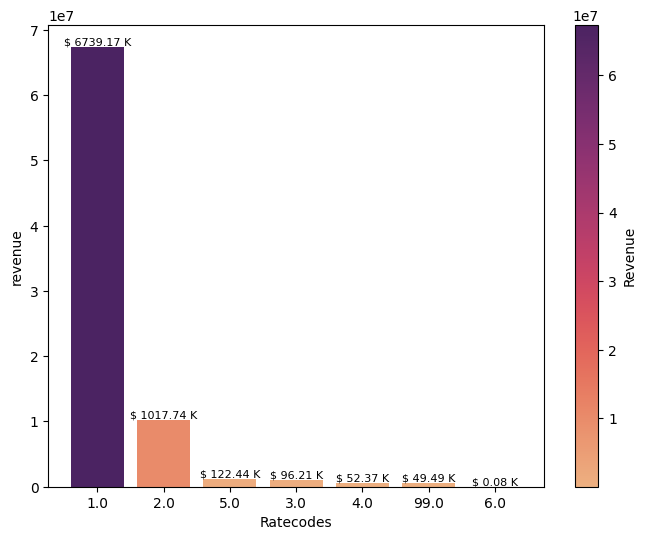

In [70]:
#choosing a colormap for bar chart illustration
colormap2 = plt.get_cmap('flare')
#mapping values to color-range from lighter to darker
normalize2 = plt.Normalize(vmin=db5['total_amount'].min(), vmax=db5['total_amount'].max())

fig, ax = plt.subplots(figsize=(8,6))
bars = plt.bar(x=db5.index.astype('str'), height=db5['total_amount'],
              color = colormap(normalize2(db5['total_amount'])))


# Add values on top of bars
values = db5['total_amount']/10000
for bar, value in zip(bars, values):
    if value >= 30000000:  # Display the value inside the bar if it's greater than or equal to 5
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"$ {value:.2f} K",
                 ha='center', va='bottom', rotation='vertical')
    else:  # Display the value above the bar if it's less than 5
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"$ {value:.2f} K",
                 ha='center', va='bottom', fontsize=8)

# display colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=colormap2, norm=normalize2), ax=ax, orientation='vertical')
cbar.set_label('Revenue')

plt.xlabel('Ratecodes')
plt.ylabel('revenue')
plt.show()